This notebook is completely used to calculate tissue specific network. (HIPPIE + Gtex)

We have used HIPPIE data to begin with and found the intersection of genes available both on hippie and gtex and built networks on top of them.

In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from statsmodels import robust
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import itertools
import networkx as nx


In [12]:
gtex_data_hippie_list = pd.read_csv('gtex_data_hippie_list.tsv',sep='\t')

In [8]:
gtex_data_hippie_list.head()

Gene  GTEX-1117F-0226-SM-5GZZ7  GTEX-1117F-0426-SM-5EGHI  \
0  NOC2L                     90.38                    92.830   
1  ISG15                     12.63                     5.886   
2   DVL1                     75.75                   125.800   
3  CCNL2                    267.80                    68.840   
4   MIB2                     33.13                    50.460   

   GTEX-1117F-0526-SM-5EGHJ  GTEX-1117F-0626-SM-5N9CS  \
0                     94.70                     67.22   
1                     23.97                     40.46   
2                     72.82                     85.86   
3                    174.80                    342.60   
4                     31.95                     63.59   

   GTEX-1117F-0726-SM-5GIEN  GTEX-1117F-1326-SM-5EGHH  \
0                     26.55                     36.08   
1                     12.75                     48.50   
2                     35.75                     47.65   
3                    102.30                    158.70   
4                     23.54                     32.72   

   GTEX-1117F-2226-SM-5N9CH  GTEX-1117F-2426-SM-5EGGH  \
0                     51.46                     85.61   
1                     13.41                     16.81   
2                    123.40                    125.90   
3                    295.60                    501.10   
4                     92.13                     85.45   

   GTEX-1117F-2526-SM-5GZY6  GTEX-1117F-2826-SM-5GZXL  \
0                    93.030                     64.55   
1                     7.023                     25.67   
2                   129.500                     72.31   
3                   344.800                    216.30   
4                    76.400                     30.14   

   GTEX-1117F-2926-SM-5GZYI  GTEX-1117F-3026-SM-5GZYU  \
0                     80.70                     80.08   
1                     12.23                     11.24   
2                     93.99                     71.20   
3                    263.00                    202.20   
4                     61.21                     29.17   

   GTEX-1117F-3226-SM-5N9CT  GTEX-111CU-0126-SM-5GZWZ  \
0                     33.08                     37.43   
1                     20.10                     21.31   
2                     97.26                     52.19   
3                    106.00                    117.70   
4                     57.42                     18.66   

   GTEX-111CU-0226-SM-5GZXC  GTEX-111CU-0326-SM-5GZXO  \
0                     74.64                    106.60   
1                     32.79                    117.30   
2                     54.94                     75.82   
3                    179.60                    180.50   
4                     30.24                     18.63   

   GTEX-111CU-0426-SM-5GZY1  GTEX-111CU-0526-SM-5EGHK  \
0                     66.55                    30.450   
1                     55.35                     4.787   
2                     39.89                    39.170   
3                    181.60                    60.860   
4                     25.88                    12.700   

   GTEX-111CU-0626-SM-5EGHL  GTEX-111CU-0726-SM-5GZYD  \
0                     67.19                     65.74   
1                     28.73                     16.27   
2                     71.56                     62.68   
3                    149.40                    121.50   
4                     27.48                     26.86   

   GTEX-111CU-0826-SM-5EGIJ  GTEX-111CU-0926-SM-5EGIK  \
0                     72.34                     53.25   
1                     23.53                     13.37   
2                     89.55                     81.03   
3                    186.50                    120.50   
4                     37.98                     22.02   

   GTEX-111CU-1026-SM-5EGIL  GTEX-111CU-1126-SM-5EGIM  \
0                     31.70                     74.39   
1                     46.67                      7.71   
2                 

In [15]:
gtex_data_hippie_list.shape

(5109, 11690)

Now let's see what each of these samples are mapped to which tissues

In [51]:
sampleid_mapping = pd.read_csv('GTEx_Tissue_Attributes.csv',sep='\t')
sampleid_mapping_rev_dist = {key:[] for key in set(sampleid_mapping['SMTS'])}
for index,row in sampleid_mapping.iterrows():
    key = row['SMTS']
    val = row ['SAMPID']
    sampleid_mapping_rev_dist[key].append(val)

In [257]:
sampleid_mapping_rev_dist.keys()

dict_keys(['Salivary Gland', 'Breast', 'Liver', 'Muscle', 'Spleen', 'Vagina', 'Adipose Tissue', 'Prostate', 'Small Intestine', 'Pituitary', 'Blood Vessel', 'Ovary', 'Blood', 'Stomach', 'Cervix Uteri', 'Fallopian Tube', 'Esophagus', 'Brain', 'Bone Marrow', 'Thyroid', 'Testis', 'Heart', 'Nerve', 'Lung', 'Skin', 'Colon', 'Pancreas', 'Bladder', 'Uterus', 'Kidney', 'Adrenal Gland'])

Now read hippie and delete all the nas and repetitions.
Whenever there's a repetition, taking the larger PPI value

In [26]:
hippie = pd.read_csv('hippie_current.txt',sep = '\t',header=None)
hippie.columns = ['Gene1', 'Gene1_Entrezid', 'Gene2', 'Gene2_Entrezid' ,'PPI_val', 'Procedure']

g1_g2 = []
for index,row in hippie.iterrows():
    g1 = row['Gene1']
    g2 = row['Gene2']
    val = '_'.join(sorted([str(g1),str(g2)]))
    g1_g2.append(val)
    
hippie['g1_g2'] = g1_g2

In [179]:
hippie = hippie.sort_values('PPI_val', ascending=False).drop_duplicates('g1_g2').sort_index()
hippie = hippie.dropna()

KeyError: Index(['g1_g2'], dtype='object')

In [29]:
hippie.head()

Gene1  Gene1_Entrezid        Gene2  Gene2_Entrezid  PPI_val  \
0  AL1A1_HUMAN             216  AL1A1_HUMAN             216     0.76   
1   ITA7_HUMAN            3679   ACHA_HUMAN            1134     0.73   
2   NEB1_HUMAN           55607   ACTG_HUMAN              71     0.65   
3   SRGN_HUMAN            5552   CD44_HUMAN             960     0.63   
4   GRB7_HUMAN            2886  ERBB2_HUMAN            2064     0.90   

                                           Procedure                    g1_g2  
0  experiments:in vivo,Two-hybrid;pmids:12081471,...  AL1A1_HUMAN_AL1A1_HUMAN  
1  experiments:in vivo,Affinity Capture-Western,a...    ACHA_HUMAN_ITA7_HUMAN  
2  experiments:in vitro,in vivo;pmids:9362513,120...    ACTG_HUMAN_NEB1_HUMAN  
3  experiments:in vivo;pmids:9334256,16189514,167...    CD44_HUMAN_SRGN_HUMAN  
4  experiments:in vitro,in vivo,Reconstituted Com...   ERBB2_HUMAN_GRB7_HUMAN

In [33]:
hippie.shape

(322837, 7)

Now lets remove all the hippie rows whose gene is not in gtex data

In [35]:
hippie = hippie.reset_index(drop=True)

In [45]:
('AT1A1' not in gtex_data_hippie_gene_list) | ('JAG1' not in gtex_data_hippie_gene_list)

True

In [108]:
'SRGN' in gtex_data_hippie_gene_list

True

In [46]:
gtex_data_hippie_gene_list = list(gtex_data_hippie_list['Gene'])
dropindex = []
count = 0
for index,row in hippie.iterrows():
    count+=1
    t1 = row['Gene1']
    t2 = row['Gene2']
    gene1 = t1.split('_')[0]
    gene2 = t2.split('_')[0]
    
    if (gene1 not in gtex_data_hippie_gene_list) | (gene2 not in gtex_data_hippie_gene_list) :
        dropindex.append(index)
    if count % 1000 == 0:
        print(count)
        

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [48]:
len(dropindex)

257909

In [49]:
hippie = hippie.drop(dropindex)

In [50]:
hippie.shape
##wow more than half has been dropped! more like 2/3rd have been dropped!

(64928, 7)

In [53]:
hippie.head()

Gene1  Gene1_Entrezid        Gene2  Gene2_Entrezid  PPI_val  \
3   SRGN_HUMAN            5552   CD44_HUMAN             960     0.63   
4   GRB7_HUMAN            2886  ERBB2_HUMAN            2064     0.90   
5   PAK1_HUMAN            5058  ERBB2_HUMAN            2064     0.73   
6   DLG4_HUMAN            1742  ERBB2_HUMAN            2064     0.87   
12  CD82_HUMAN            3732  ERBB2_HUMAN            2064     0.73   

                                            Procedure                   g1_g2  
3   experiments:in vivo;pmids:9334256,16189514,167...   CD44_HUMAN_SRGN_HUMAN  
4   experiments:in vitro,in vivo,Reconstituted Com...  ERBB2_HUMAN_GRB7_HUMAN  
5   experiments:in vivo,Affinity Capture-Western,a...  ERBB2_HUMAN_PAK1_HUMAN  
6   experiments:in vivo,Two-hybrid,Affinity Captur...  DLG4_HUMAN_ERBB2_HUMAN  
12  experiments:in vivo,Affinity Capture-Western,a...  CD82_HUMAN_ERBB2_HUMAN

In [181]:
m = ['Gene1','Gene2','PPI_val']
hippie = hippie[m]
hippie = hippie.reset_index(drop=True)
hippie  = hippie[hippie['PPI_val']>0]

In [182]:
hippie.head()

Gene1        Gene2  PPI_val
0  SRGN_HUMAN   CD44_HUMAN     0.63
1  GRB7_HUMAN  ERBB2_HUMAN     0.90
2  PAK1_HUMAN  ERBB2_HUMAN     0.73
3  DLG4_HUMAN  ERBB2_HUMAN     0.87
4  CD82_HUMAN  ERBB2_HUMAN     0.73

In [264]:
hippie.shape

(63408, 3)

In [265]:
#pickle.dump( hippie, open( "hippie_cleaned.p", "wb" ) )

Now for the bigguns

In [187]:
gene_exp_dict_ppi = {}
count = 0
for index,row in gtex_data_hippie_list.iterrows():
    count+=1
    gene = list(row)[0]
    data = list(row)[1:-1]
    data = np.array(data).astype(np.float)
    gene_exp_dict_ppi[gene] = data
    if count%1000 == 0:
        print(count)

def gene_threshold_dict(gene_list, thresh_percentile):
    gene_threshold_dict = {}
    for gene in gene_list:
        try:
            data = gene_exp_dict_ppi[gene]
            thresh = np.percentile(data,thresh_percentile)
            gene_threshold_dict[gene] = thresh
        except:
            #print(gene + 'gene not found in gtex')
            continue
    return gene_threshold_dict
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

1000
2000
3000
4000
5000


In [189]:
def genepair_edge_exp_ratio(g1,g2,exp_df,exp_threshold_dict):
    exp_df = exp_df.set_index('Gene')
    sample_df = exp_df.T
    sample_df_short = sample_df.loc[(sample_df[g1] > exp_threshold_dict[g1]) & (sample_df[g2] > exp_threshold_dict[g2])]
    
    total_vals,x = sample_df.shape
    shortlist_vals,x = sample_df_short.shape
    return shortlist_vals/total_vals

In [208]:
def gene_edge_exp_ratio(exp_df,exp_threshold_dict):
    gene_list = list(exp_df['Gene'])
    print(gene_list[:5])
    exp_df = exp_df.set_index('Gene')
    sample_df = exp_df.T
    gene_edge_exp_ratio_dict = {}
    
    for g in gene_list:
        sample_df_short = sample_df[sample_df[g] > exp_threshold_dict[g]]
        total_vals,x = sample_df.shape
        shortlist_vals,x = sample_df_short.shape
        ratio = shortlist_vals/total_vals
        gene_edge_exp_ratio_dict[g] = ratio
    return gene_edge_exp_ratio_dict

In [203]:
def tissue_specific_exp_data(tissue,samp_gtex_data,sampleid_mapping_rev_dist = sampleid_mapping_rev_dist):
    vals =  sampleid_mapping_rev_dist[tissue]
    gtex_cols = list(samp_gtex_data.columns)
    inters_cols = intersection(vals, gtex_cols)
    inters_cols = ['Gene'] + inters_cols
    return samp_gtex_data[inters_cols]
    

In [233]:
def tissue_network(tissue_name, gene_exp_data = gtex_data_hippie_list ,ppi_network = hippie,
                   gene_threshold_level = 25, PPI_threshold = 0.3, edge_percentage_threshold = 0.5):
    gene_list = list(gene_exp_data['Gene'])
    exp_threshold_dict = gene_threshold_dict(gene_list, gene_threshold_level)
    exp_data_short = tissue_specific_exp_data(tissue_name,gene_exp_data)
    g1_list = []
    g2_list = []
    PPI_val = []
    ratio_val = []
    count = 0
    for index,row in ppi_network.iterrows():
        count+=1
        t1 = row['Gene1']
        t2 = row['Gene2']
        ppi = row['PPI_val']
        gene1 = t1.split('_')[0]
        gene2 = t2.split('_')[0]
        ratio = genepair_edge_exp_ratio(gene1,gene2,exp_data_short,exp_threshold_dict)
        g1_list.append(gene1)
        g2_list.append(gene2)
        PPI_val.append(ppi)
        ratio_val.append(ratio)
        if count%1000 == 0:
            print(count)
        tissue_network_df = pd.DataFrame({'Gene1':g1_list,'Gene2':g2_list,
                                     'PPI_val': PPI_val, 'Ratio_val': ratio_val})
    
    gene_edge_exp_ratio_dict = gene_edge_exp_ratio(exp_df = exp_data_short,exp_threshold_dict=exp_threshold_dict)
    tissue_network_df['Gene1_ratio']= tissue_network_df['Gene1'].map(gene_edge_exp_ratio_dict)
    tissue_network_df['Gene2_ratio']= tissue_network_df['Gene2'].map(gene_edge_exp_ratio_dict)
    

    return tissue_network_df

In [219]:
a = tissue_network('Kidney')

['NOC2L', 'ISG15', 'DVL1', 'CCNL2', 'MIB2']


In [220]:
a = a.sort_values('Gene1')

a.head(20)

Gene1  Gene2  PPI_val  Ratio_val  Gene1_ratio  Gene2_ratio  \
68   ARAF   RRAS     0.75   0.555556     0.555556     0.977778   
91  BCAR1    LYN     0.90   0.511111     0.866667     0.511111   
85  CASP3    LYN     0.55   0.244444     0.244444     0.511111   
47    CBL    FGR     0.83   0.333333     0.333333     0.644444   
75    CBL    LYN     0.96   0.333333     0.333333     0.511111   
98   CBLC    LYN     0.75   0.511111     1.000000     0.511111   
56   CBX1   PIM1     0.74   0.333333     0.377778     0.533333   
55   CBX3   PIM1     0.89   0.422222     0.511111     0.533333   
50   CCR3    FGR     0.73   0.422222     0.644444     0.644444   
73    CD2   CD59     0.62   0.555556     0.733333     0.644444   
77   CD36    LYN     0.87   0.244444     0.244444     0.511111   
52    CD4   CD38     0.62   0.400000     0.911111     0.400000   
14    CD4   CD44     0.62   0.466667     0.911111     0.466667   
41   CD81    KIT     0.73   0.711111     0.711111     0.977778   
4    CD82  ERBB2     0.73   0.488889     0.488889     1.000000   
70    CD9   CD59     0.62   0.644444     0.933333     0.644444   
35   CRKL    KIT     0.88   0.155556     0.155556     0.977778   
49   DAB2    FGR     0.85   0.644444     1.000000     0.644444   
3    DLG4  ERBB2     0.87   0.533333     0.533333     1.000000   
90   DLG4    LYN     0.59   0.400000     0.533333     0.511111   

    Conditional_Ratio  
68           1.022727  
91           1.153846  
85           1.956522  
47           1.551724  
75           1.956522  
98           1.000000  
56           1.654412  
55           1.548913  
50           1.016647  
73           1.175549  
77           1.956522  
52           1.097561  
14           1.097561  
41           1.022727  
4            1.000000  
70           1.071429  
35           1.022727  
49           1.000000  
3            1.000000  
90           1.467391

In [266]:
a.columns

Index(['Gene1', 'Gene2', 'PPI_val', 'Ratio_val', 'Gene1_ratio', 'Gene2_ratio',
       'Conditional_Ratio'],
      dtype='object')

In [174]:
a_short = a[(a['Ratio_val'] > 0.50) & (a['PPI_val'] > 0) ]

In [175]:
a_short.shape

(12379, 4)

In [161]:
G = nx.from_pandas_edgelist(a_short, 'Gene1', 'Gene2', 'PPI_val')

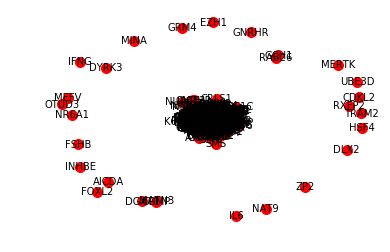

In [176]:
import matplotlib.pyplot as plt
import networkx as nx


elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['PPI_val'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['PPI_val'] <= 0.5]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()

In [177]:
a[a['Gene1'] == 'NAT9' ]

Gene1  Gene2  PPI_val  Ratio_val
4720   NAT9  SMAD1     0.59   0.377778
64222  NAT9   FLII     0.63   0.444444
45303  NAT9   NAT9     0.63   0.622222
61225  NAT9   MPP6     0.63   0.488889

In [234]:
lung_network = tissue_network('Lung')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
['NOC2L', 'ISG15', 'DVL1', 'CCNL2', 'MIB2']


In [240]:
div = []
for index,row in lung_network.iterrows():
    g1 = row['Gene1_ratio']
    g2 = row['Gene2_ratio']
    g1_g2 = row['Ratio_val']
    try:
        div_val = g1_g2/(g1*g2)
        div.append(div_val)
    except:
        div.append(np.nan)
lung_network['Conditional_Ratio'] = div

lung_network = lung_network.sort_values('Conditional_Ratio')
lung_network = lung_network.dropna()

In [252]:
lung_network.shape

(63357, 7)

In [251]:
lung_network.head()

Gene1  Gene2  PPI_val  Ratio_val  Gene1_ratio  Gene2_ratio  \
57169  IFNA4  IFNA8     0.63   0.000000     0.025761     0.021077   
9202    ASIP   MC3R     0.52   0.016393     0.826698     0.028103   
3649   NR0B1   CSN2     0.88   0.009368     0.374707     0.035129   
59466  SYT12   PDK2     0.63   0.161593     0.498829     0.430913   
59955  HSFY1  POTEF     0.63   0.004684     0.007026     0.882904   

       Conditional_Ratio  
57169           0.000000  
9202            0.705619  
3649            0.711667  
59466           0.751761  
59955           0.755084

In [253]:
#pickle.dump( lung_network, open( "lung_network.p", "wb" ) )

In [254]:
adipose_network = tissue_network('Adipose Tissue')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
['NOC2L', 'ISG15', 'DVL1', 'CCNL2', 'MIB2']


In [255]:
div = []
for index,row in adipose_network.iterrows():
    g1 = row['Gene1_ratio']
    g2 = row['Gene2_ratio']
    g1_g2 = row['Ratio_val']
    try:
        div_val = g1_g2/(g1*g2)
        div.append(div_val)
    except:
        div.append(np.nan)
adipose_network['Conditional_Ratio'] = div

adipose_network = adipose_network.sort_values('Conditional_Ratio')
adipose_network = adipose_network.dropna()

In [256]:
#pickle.dump( adipose_network, open( "adipose_network.p", "wb" ) )

In [258]:
heart_network = tissue_network('Heart')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
['NOC2L', 'ISG15', 'DVL1', 'CCNL2', 'MIB2']


In [263]:
#pickle.dump( heart_network, open( "heart_network.p", "wb" ) )

In [260]:
div = []
for index,row in heart_network.iterrows():
    g1 = row['Gene1_ratio']
    g2 = row['Gene2_ratio']
    g1_g2 = row['Ratio_val']
    try:
        div_val = g1_g2/(g1*g2)
        div.append(div_val)
    except:
        div.append(np.nan)
heart_network['Conditional_Ratio'] = div

heart_network = heart_network.sort_values('Conditional_Ratio')
heart_network = heart_network.dropna()